# Regularized Regression

**Yuanzhe(Roger) Li,  2020-01-21**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets
from sklearn.model_selection import GridSearchCV

## Outline
- Recap of Linear Regression
- Ridge Regression
- LASSO
- `glmnet`/`ElasticNet`

## Linear regression recap

Recall that in the context of linear regression $\mathbf{y} = \mathbf{X \beta} + \mathbf{\epsilon}$ where $\epsilon_i \overset{\text{iid}}{\sim} \mathcal{N}(0,\sigma^2)$.

Say $\mathbf{y} \in \mathbb{R}^n$, the negative log-likelihood is 
$$L(\mathbf{\beta}|\mathbf{X, y}) = \dfrac{n}{2}\log (2\pi \sigma^2) + \dfrac{1}{2\sigma^2}\sum_{i=1}^n(y_i -\mathbf{x}_i^T\mathbf{\beta})^2$$
Notice that the **MLE** is also the least squares soltion 
$$\mathbf{\beta}^* = \mathbf{\beta}_{\text{MLE}} = \mathbf{\beta}_{\text{LS}} = \underset{\mathbf{\beta}}{\text{arg min}}\sum_{i=1}^n(y_i -\mathbf{x}_i^T\mathbf{\beta})^2$$ 

## Linear regression recap (continued)
In matrix form 
$$\begin{align}
\mathbf{\beta}^* & = \underset{\mathbf{\beta}}{\text{arg min}} [(\mathbf{y - X\beta})^T(\mathbf{y - X\beta})] \\ 
& = \underset{\mathbf{\beta}}{\text{arg min}}[\mathbf{y}^T\mathbf{y} -2\mathbf{\beta}^T\mathbf{X}^T\mathbf{y} + \mathbf{\beta}^T \mathbf{X}^T\mathbf{X \beta}]  \end{align}$$
Denote $\mathbf{e} = \mathbf{y - X\beta} $, and set 

$$\dfrac{\partial \mathbf{e}^T \mathbf{e}}{\partial \mathbf{\beta}} = -2 \mathbf{X}^T\mathbf{y} + 2 \mathbf{X}^T\mathbf{X}\mathbf{\beta} = \mathbf{0}$$

we have 
$$
\begin{align}
& \mathbf{X}^T\mathbf{X}\mathbf{\beta} = \mathbf{X}^T\mathbf{y} \\ 
\Rightarrow \quad & \mathbf{\beta}^* = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T \mathbf{y}
\end{align}
$$

## Penalized loss function
The loss function of regularized regression takes the following form:

$$Loss(\mathbf{\beta}) = \mathbf{E}(\mathbf{\beta}) + \frac{\lambda}{2} \cdot \mathbf{P}(\mathbf{\beta})$$
where 

- $\mathbf{E}(\mathbf{\beta}) = \dfrac{1}{2}\sum_{i=1}^n(y_i -\mathbf{x}_i^T\mathbf{\beta})^2$ is the sum-of-squares error,
- $\mathbf{P}$ is a penalty function that aims at regularizing the unknown parameters, and 
- $\lambda$ is a hyperparameter that controls the tradeoff between the two components of the loss function.

## Ridge regression
### Penalty
One choice of $P_\lambda$ that favors small regression coefficients is to penalize the sum of squares of the regression coefficients:

$$P (\mathbf{\beta}) = \sum_{j=1}^p\beta_j^2$$

and the whole loss function becomes

$$Loss(\mathbf{\beta}) = \frac{1}{2}\sum_{i=1}^n(y_i -\mathbf{x}_i^T\mathbf{\beta})^2 + \frac{\lambda}{2}\sum_{j=1}^p\beta_j^2$$

which is known as ***ridge regression*** in statistics.

## Ridge regression
### Solution

Since the loss function of ridge regression is differentiable, it has a simple closed-form solution

$$\mathbf{\beta}_{\text{ridge}} = (\mathbf{X}^T\mathbf{X} + \lambda \mathbf{I})^{-1}\mathbf{X}^T \mathbf{y}$$

The solution is similar to the least squares solution with an extra diagonal matrix (i.e., $\lambda \mathbf{I}$) to be inverted, which improves the numeric stability of the system when $\mathbf{X}^T\mathbf{X}$ is close to being non-invertible 

*Question: what does that mean in practice?*




## Ridge regression
### A simple example

In [2]:
# Generate data
np.random.seed(2)
x1 = np.random.normal(size=20)
x2 = np.random.normal(loc = x1, scale=0.01, size=20)
y = np.random.normal(loc = 3 + x1 + x2, size=20)
design_mat = np.hstack((
    np.array(x1).reshape(20,1), 
    np.array(x2).reshape(20,1)
))

In [3]:
# Train an OLS model
reg_ols = linear_model.LinearRegression()
reg_ols.fit(design_mat, y)
reg_ols.coef_

array([ 14.51690508, -12.25821163])

In [4]:
# Use ridge penalty
reg_ridge = linear_model.Ridge(alpha = 1.0)
reg_ridge.fit(design_mat, y)
reg_ridge.coef_

array([1.10585803, 1.08303544])

## Ridge regression
### Bayesian justification for the ridge penalty

- (**TL;DR**) Regularized least square with ridge penalty is equivalent to the maximum a posteriori (MAP) estimator (up to constant factor) in the Bayesian framework for linear regression with istropic zero-mean Gaussian priors on the parameters. 

### Bayesian framework
- Linear regression in the context of Bayesian inference, in which a prior distribution over the model's parameters $\mathbf{\beta}$ is assumed, and the goal is to find the posterior distribution of the $\mathbf{\beta}$.

- Let $p(\mathbf{y}|\mathbf{\beta})$ denote the distribution of $\mathbf{y}$ given $\mathbf{\beta}$, and $p(\mathbf{\beta})$ the prior for $\mathbf{\beta}$, the posterior density is

$$p(\mathbf{\beta}|\mathbf{y}) = \dfrac{p(\mathbf{y}|\mathbf{\beta})p(\mathbf{\beta})}{p(\mathbf{y})} \propto p(\mathbf{y}|\mathbf{\beta})p(\mathbf{\beta})$$

or 

$$\log p(\mathbf{\beta}|\mathbf{y})  = \log p(\mathbf{y}|\mathbf{\beta}) + \log p(\mathbf{\beta}) + \text{constant}$$

- From a Bayesian perspective, one can think of the penalty as arising from a formal prior distribution on the parameters.

### Bayesian linear regression - setup

Let's revisit the linear model $\mathbf{y} = \mathbf{X \beta} + \mathbf{\epsilon}$ where $\epsilon_i \overset{\text{iid}}{\sim} \mathcal{N}(0, \tau^{-1})$ with a bayesian treatment as follows:

- Prior $\mathbf{\beta} \sim \mathcal{N}(\mathbf{m_0, S_0})$
- Likelihood $p(\mathbf{y}|\mathbf{\beta}) = \sum_{i=1}^n \mathcal{N}(y_i|\mathbf{x_i}^T\mathbf{\beta}, \tau^{-1})$
- Posterior $\mathbf{\beta}|\mathbf{y} \sim \mathcal{N}(\mathbf{\beta}|\mathbf{m_n, S_n})$

Notice that Gaussian is [self-conjugate](https://en.wikipedia.org/wiki/Conjugate_prior) for Gaussian likelihood function, we can use the fact that the posterior is also Gaussian to figure out the parameterization.

### Bayesian linear regression - posterior

- For the posterior distribution, we have 

$$
\begin{align}
\mathbf{m_n} &= \mathbf{S_n(S_0^{-1}\mathbf{m_0} + \tau\mathbf{X}^T\mathbf{y}})\\
\mathbf{S_n}^{-1} &= \mathbf{S_0}^{-1} + \tau \mathbf{X}^T\mathbf{X}
\end{align}
$$

- Assume the prior is a zero-mean isotropic Gaussian, i.e., $\mathbf{\beta} \sim \mathcal{N}(\mathbf{0}, \alpha^{-1}\mathbf{I})$. The parameterization of the posterior then becomes

$$
\begin{align}
\mathbf{m_n} &= \tau \mathbf{S_n X}^T\mathbf{y}\\
\mathbf{S_n}^{-1} &= \alpha \mathbf{I} + \tau \mathbf{X}^T\mathbf{X}
\end{align}
$$

### Connection between bayesian linear regression and ridge regression

- Since the posterior is Gaussian, we have 

$$\mathbf{\beta}_{\text{MAP}} = \mathbf{m_n} = (\mathbf{X}^T\mathbf{X} + \dfrac{\alpha}{\tau}\mathbf{I})^{-1}\mathbf{X}^T\mathbf{y}$$ 

which is the same as the ridge solution $(\mathbf{X}^T\mathbf{X} + \lambda \mathbf{I})^{-1}\mathbf{X}^T \mathbf{y}$ with $\lambda = \alpha / \tau$.


- Alternatively, if we compare the objective fuctions. Maximization of the log of the posterior probability below w.r.t $\mathbf{\beta}$

$$
\begin{align}
\log p(\mathbf{\beta}|\mathbf{y})  &= \log p(\mathbf{y}|\mathbf{\beta}) + \log p(\mathbf{\beta}) + \text{constant}\\
&= - \dfrac{\tau}{2}\sum_{i=1}^{n}(y_i -\mathbf{x}_i^T\mathbf{\beta})^2 - \dfrac{\alpha}{2}\mathbf{\beta}^T
\mathbf{\beta} + \text{constant}
\end{align}
$$

again, is equivalent to the minimization of the regularized (ridge penalty) least squares with $\lambda = \alpha / \tau$.



### Bayesian versus frequentist view
- Notice that when the prior is infinitely broad, i.e., $\mathbf{S_0}=\alpha^{-1}\mathbf{I}$ and $\alpha \rightarrow 0$, $\mathbf{\beta}_{\text{MAP}}$ is the same as the MLE estimator.

$$\lim_{\alpha \rightarrow 0}\mathbf{\beta}_{\text{MAP}} = \lim_{\alpha \rightarrow 0}[(\mathbf{X}^T\mathbf{X} + \dfrac{\alpha}{\tau}\mathbf{I})^{-1}\mathbf{X}^T\mathbf{y}] = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y} = \mathbf{\beta}_{\text{MLE}}$$

- Despite of the connection between  $\mathbf{\beta}_{\text{MAP}}$ and $\mathbf{\beta}_{\text{ridge}}$ or $\mathbf{\beta}_{\text{MLE}}$ , the similarity between Bayesian and Frequentist breaks down in other inferential respects.

### Choosing $\lambda$ in ridge regression
- Common model fitness measures for OLS such as [Mallows's $C_p$](https://en.wikipedia.org/wiki/Mallows%27s_Cp), [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion), and [BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion) also work for ridge regression.
- In practice, we can use k-fold cross validation to select $\lambda$ with the CV performance.

### Example of using cross validation to choose $\lambda$ for ridge regression

- Let's use simulated dataset with `effective_rank=5`.

In [5]:
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=1000, n_features=500, effective_rank = 5,
                          n_informative = 400, noise = 1.5, random_state=10)

In [6]:
# Define plotting functions
def plot_ridge_cv(reg_cv, dpi=100):
    """Plot mean and sd of cv scores from a GridSearchCV for ridge regression"""
    param = list(reg_cv.param_grid.keys())[0]
    grid = reg_cv.param_grid[param]
    score, std = reg_cv.cv_results_['mean_test_score'], reg_cv.cv_results_['std_test_score']
    best_param, best_score = reg_cv.best_params_['alpha'], reg_cv.best_score_
    fig, ax=plt.subplots(dpi=dpi)
    ax.errorbar(grid, -score, yerr=std)
    ax.set_xscale('log')
    ax.set_xlabel(r'$\lambda$')
    ax.set_ylabel("Root mean-squared error")
    title = r'Best $\lambda$' + f': {round(best_param,5)}, best ' + r'$\overline{rmse}$' + f': {round(-best_score, 3)}'
    ax.set_title(title)
    ax.plot()

In [7]:
reg_ridge = linear_model.Ridge()
params = {'alpha': np.exp(np.arange(-20,10,2))}
reg_cv = GridSearchCV(reg_ridge, params, scoring = 'neg_root_mean_squared_error', cv=10)

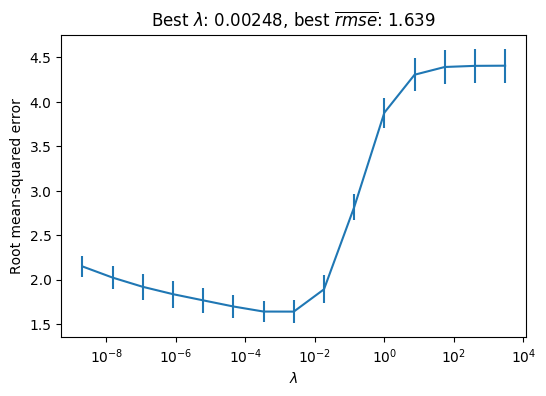

In [8]:
reg_cv.fit(X, y)
plot_ridge_cv(reg_cv)

### Remarks on ridge regression
- Ridge penalty tends to push the parameters of correlated features together, as OLS might allow one to be wildly positive and the other negative.
- The shrinkage in model parameters brought by ridge regression reduces noice and identify true signals in model effects.
- However, one major limitation of ridge regression is that it retains all of parameters non-zero, while a smaller subset of strong features are usually preferred for interpretability reasons.

## LASSO

- In the frame of regularized least squares, LASSO uses $\ell_1$ penalty instead of $\ell_2$ penalty in ridge regression, i.e.,

$$Loss(\mathbf{\beta}) = \frac{1}{2}\sum_{i=1}^n(y_i -\mathbf{x}_i^T\mathbf{\beta})^2 + \frac{\lambda}{2}\sum_{j=1}^p|\beta_j|$$

- LASSO stands for least absolute shrinkage and selectin operator.
    - *Shrinkage*: Similar to ridge regression, lasso penalizes large parameters and shrinks estimates towards zero
    - *Selection*: Unlike ridge, lasso actually pushes parameter estiamtes to zero and produces sparse solutions.


### Why does LASSO generate sparse solutions?
- Geometric view
![Why LASSO can lead to sparsity?](./assets/images/bishop_fig_34_lasso.png)

- Ridge:  $\min_{\mathbf{\beta}}||\mathbf{y}-\mathbf{X\beta}||_2^2 \quad \text{s.t.} ||\mathbf{\beta}||_2 \leq t$
- LASSO:  $\min_{\mathbf{\beta}}||\mathbf{y}-\mathbf{X\beta}||_2^2 \quad \text{s.t.} ||\mathbf{\beta}||_1 \leq t$

### Solving LASSO
- Unlike ridge regression, lasso is not strictly convex when $\mathbf{X}^T\mathbf{X}$ is not full rank, thus it may not have a unique solution. 

- There are two popular algorithms (as currently inplemented in `sklearn`) to solve LASSO models.
    - Coordinate descent (CD)
    - Least-angle regression (LARS)

#### Coordinate descent


- Idea: minimization of a multivariate function $f: \mathbb{R}^n \rightarrow \mathbb{R}$ can be repeatedly solving univariate optimization along one direction.
    - Start with $\mathbf{x}^0 = (x_1^0, ..., x_n^0)$,
    - at round $k+1$, define $\mathbf{x}^{k+1}$ from $\mathbf{x}^k$ by iteratively solving the single-variable optimization problem: $$x_i^{k+1} = \text{arg}\min_z f(x_1^{k+1},..., x_{i-1}^{k+1}, z, x_{i+1}^{k}, ..., x_{n}^k), \quad \text{for }i=1,...,n$$
    - Repeat until convergence.

#### When does coordinate-wise minimization work?

- $f: \mathbb{R}^n \rightarrow \mathbb{R}$ convex and differentiable? YES.
- $f: \mathbb{R}^n \rightarrow \mathbb{R}$ convex but not differentiable? NO.
- However, if $f(\mathbf{x}) = g(\mathbf{x}) + \sum_i^n h_i(x_i)$ with $g$ convex and differentiable, and each $h_i$ convex, the answer is YES again.
- Notice LASSO meets the above requirement with $g(\mathbf{\beta}) = \dfrac{1}{2}||\mathbf{y} - \mathbf{X\beta}||^2$ and $h_i(\beta_i) = \lambda|\beta_i|$ for $i = 1,...,p$.

#### CD scheme for LASSO
- We repeatedly cycle through the model parameters, and in each step, optimize only a single parameter ($\beta_j$)
- To update $\beta_j$, we solve the following univariate minimization problem
$$\min_{\beta_j\in \mathbb{R}} \frac{1}{2}||\mathbf{y} - \sum_{i: i\neq j}\mathbf{X}_{:i}\beta_i - \mathbf{X}_{:j}\beta_j||^2 + \lambda |\beta_j| + \lambda \sum_{i:i\neq j}|\beta_i|$$
where $\mathbf{X}_{:i}$ is the $i$-th column of the design matrix $\mathbf{X} \in \mathbb{R}^{n \times d}$.
- The solution to the above problem turns out to be 
$$\beta_j \leftarrow \psi_{\text{st}}( \dfrac{\mathbf{X}_{:j}^T(\mathbf{y}- \sum_{i:i\neq j}\mathbf{X}_{:i}\beta_i)}{||\mathbf{X}_{:j}||^2}; \dfrac{\lambda}{||\mathbf{X}_{:j}||^2})$$
where $\psi_{\text{st}}$ is the *soft thresholding* operator.
- More on $\psi_{\text{st}}$ and how to solve the univariate lasso (it's non-differentiable) later, but we cycle through $\beta_j$ for $j = 1,..., d$ and repeat until convergence.

#### Subgradients and optimality
- For $f: \mathbb{R}^n \rightarrow \mathbb{R}$, its ***subgradient*** at $x$ is defined as 
$$\partial f(x) = \{s\in \mathbb{R}^n| f(z)\geq f(x) + s^T(z-x), \forall z \in \mathbf{dom} f\}$$
- If $f$ is convex and differentiable, than its gradient at $x$ is a subgradient. If $f$ is not differentiable, it can have multiple subgradients.
- **Theorem**: for any convex function $f(\mathbf{x})$, $\mathbf{x}^*$ is an optimal solution $\iff$ $\mathbf{0} \in \partial f(\mathbf{x}^*)$, where $\partial f(\mathbf{x})$ is the set of all subgradients at $\mathbf{x}$.
    - Use $f(\beta) = |\beta|$ as an example, it's subgradient $s$ is 
    $$\begin{cases}
      s = \text{sign}(\beta), & \beta \neq 0 \\
      s \in [-1, 1], & \beta = 0
    \end{cases}$$
    - Notice the optimal solution $\beta^* = 0 \in [-1, 1]$.

#### Univariate LASSO
- Now let's look at the univariate LASSO. WLOG, we consider $\min_{\beta \in \mathbb{R}} \frac{1}{2}||\mathbf{y}-\beta \mathbf{z}||^2+\lambda |\beta|$, which is convex but not differentiable due to the addition of the $\ell_1$ regularization term.
    - its subgradient $g = \mathbf{z}^T(\beta \mathbf{z}-\mathbf{y}) + \lambda \cdot s$ where $s$ is the subgradient of $|\beta|$
    - The optimality happens when $0 \in g \iff \mathbf{z}^T\mathbf{y} - \beta ||\mathbf{z}||^2 \in \lambda s$, let's take this case by case
        - If $\beta = 0$, we have  $\mathbf{z}^T\mathbf{y} \in [-\lambda, \lambda]$, i.e., $|\mathbf{z}^T\mathbf{y}| \leq \lambda$
        - If $\beta > 0$, we have $\beta = \dfrac{\mathbf{z}^T\mathbf{y}}{||\mathbf{z}||^2} - \dfrac{\lambda}{||\mathbf{z}||^2} > 0$, i.e., $\mathbf{z}^T\mathbf{y} > \lambda$
        - Finally, if $\beta < 0$, we have $\beta = \dfrac{\mathbf{z}^T\mathbf{y}}{||\mathbf{z}||^2} + \dfrac{\lambda}{||\mathbf{z}||^2} < 0$, i.e., $\mathbf{z}^T\mathbf{y} < -\lambda$

#### Univariate LASSO (continued)
- So we have verified that in univariate case, the LASSO estimator is $\hat{\beta} = \psi_{\text{st}}(\dfrac{\mathbf{z}^Ty}{||\mathbf{z}||^2}; \dfrac{\lambda}{||\mathbf{z}||^2})$, where the ***soft thresholding*** operator is defined as follows:

$$ \psi_{\text{st}}(x; \lambda)= \begin{cases}
  x - \lambda, & \text{if } x \geq \lambda, \\
  x + \lambda, & \text{if } x \leq -\lambda \\
  0, &         \text{else}
\end{cases}$$

- Hence in the multivariate setting, coordinate update is given by
$$\beta_j \leftarrow \psi_{\text{st}}( \dfrac{\mathbf{X}_{:j}^T(\mathbf{y}- \sum_{i:i\neq j}\mathbf{X}_{:i}\beta_i)}{||\mathbf{X}_{:j}||^2}; \dfrac{\lambda}{||\mathbf{X}_{:j}||^2})$$
as previously shown.

#### LARS and LASSO path
- LARS is the first efficient algorithm for LASSO is (in my mind) more intuitively related to variable selection property of LASSO.

- Basic steps of LARS are as follows:
    - Start with all parameters $\beta$ equal to zero ($\lambda_{\infty}$)
    - Lower $\lambda$ to allow the parameter $\beta_j$ to the predictor $\mathbf{x}_j$ that is most correlated with $\mathbf{y}$ into the model.
    - Increase $\beta_j$ in the direction of the sign of corr$(\mathbf{x}_j, \mathbf{y})$ and take residuals $\mathbf{r} = \mathbf{y}-\hat{\mathbf{y}}$ along the way. Stop when another predictor $\mathbf{x}_k$ has as much correlation with $\mathbf{r}$ as $\mathbf{x}_j$.
    - Include $\mathbf{x}_k$ and increase ($\beta_j, \beta_k$) in their joint least squares direction (i.e., projection of $r$ onto $[\beta_j, \beta_k]^T$) until the next predictor $\mathbf{x}_m$ reaches the necessary level of correlation with $\mathbf{r}$, all with $\lambda$ lowered along the way.
    - Repeat until $\lambda$ hits a predetermined threshold or small enough for all the variables to be included.

In [14]:
def run_lars_example(dpi=100):
    """Run LARS example from sklearn
    https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_lars.html
    """
    X, y = datasets.load_diabetes(return_X_y=True)
    _, _, coefs = linear_model.lars_path(X, y, method='lasso', verbose=True)

    xx = np.sum(np.abs(coefs.T), axis=1)
    xx /= xx[-1]
    fig, ax=plt.subplots(dpi=dpi)
    ax.plot(xx, coefs.T)
    ymin, ymax = plt.ylim()
    ax.vlines(xx, ymin, ymax, linestyle='dashed')
    ax.set_xlabel('|coef| / max|coef|')
    ax.set_ylabel('Coefficients')
    ax.set_title('LASSO Path')
    ax.autoscale(enable=False, tight=True)

#### LARS example
- Let's look at an example of using LARS to compute the LASSO path along the regularization parameter.

.

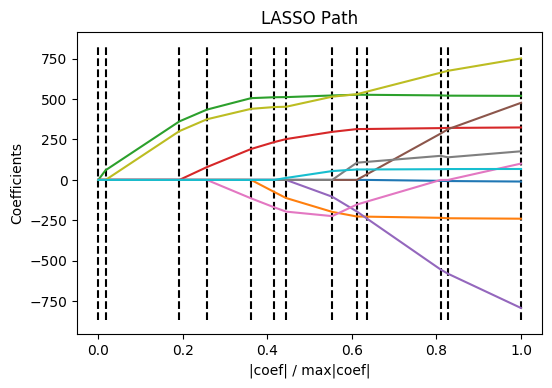

In [15]:
run_lars_example()

#### Remarks on LARS
- Notice that when solving LASSO using LARS, we always proceed in the direction such that every active predictor is equally correlated with the residual $\mathbf{r}$, which is consistent with the KKT conditions of LASSO (not covered here).

- Nevertheless, coordinate descent and variant has become more popular due to its simplicity and flexibility.

### Bayesian interpretation of LASSO

### Remarks on LASSO

## ElasticNet